In [1]:
%load_ext autoreload
%autoreload 2

# Librerías

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

# Análisis de datos

In [3]:
df = pd.read_csv('Data/pf_suvs_i302_1s2025.csv')
df = df.drop(df.columns[0], axis=1)
mask = df['Moneda'] == '$'
df.loc[mask, 'Precio'] = df.loc[mask, 'Precio'] / 1185
df.drop(columns=['Moneda'], inplace=True)
df.drop(columns = ['Tipo de carrocería'],inplace=True)
idx = df[df['Año'] == 436694.0].index
df.drop(idx, inplace=True)


In [4]:
df.info()    
df.describe(include='all')  


<class 'pandas.core.frame.DataFrame'>
Index: 18253 entries, 0 to 18253
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Marca                    18253 non-null  object 
 1   Modelo                   18253 non-null  object 
 2   Año                      18253 non-null  float64
 3   Versión                  18253 non-null  object 
 4   Color                    17864 non-null  object 
 5   Tipo de combustible      18253 non-null  object 
 6   Puertas                  18253 non-null  float64
 7   Transmisión              18238 non-null  object 
 8   Motor                    18215 non-null  object 
 9   Con cámara de retroceso  4691 non-null   object 
 10  Kilómetros               18253 non-null  object 
 11  Título                   18253 non-null  object 
 12  Precio                   18253 non-null  float64
 13  Descripción              18253 non-null  object 
 14  Tipo de vendedor         18

,Marca,Modelo,Año,Versión,Color,Tipo de combustible,Puertas,Transmisión,Motor,Con cámara de retroceso,Kilómetros,Título,Precio,Descripción,Tipo de vendedor
count,18253,18253,18253.000000,18253,17864,18253,18253.000000,18238,18215,4691,18253,18253,18253.000000,18253,18253
unique,47,137,NaN,2072,70,8,NaN,4,271,2,2175,2220,NaN,12141,3
top,Ford,Ecosport,NaN,1.6 Exclusive Cvt,Gris,Nafta,NaN,Automática,1.6,Sí,0.0,Nissan Kicks 1.6 Exclusive Cvt,NaN,El vendedor no incluyó una descripción del pro...,concesionaria
freq,2161,1569,NaN,320,5468,16066,NaN,12281,4132,3731,4237,320,NaN,2260,8509
mean,NaN,NaN,2018.983619,NaN,NaN,NaN,18.168027,NaN,NaN,NaN,NaN,NaN,27598.044551,NaN,NaN
std,NaN,NaN,5.514331,NaN,NaN,NaN,891.790545,NaN,NaN,NaN,NaN,NaN,20297.864206,NaN,NaN
min,NaN,NaN,1981.000000,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,100.421941,NaN,NaN
25%,NaN,NaN,2016.000000,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,16033.755274,NaN,NaN
50%,NaN,NaN,2019.000000,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,23500.000000,NaN,NaN
75%,NaN,NaN,2024.000000,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,NaN,32489.450633,NaN,NaN


In [5]:
df.isnull().sum()     


Marca                          0
Modelo                         0
Año                            0
Versión                        0
Color                        389
Tipo de combustible            0
Puertas                        0
Transmisión                   15
Motor                         38
Con cámara de retroceso    13562
Kilómetros                     0
Título                         0
Precio                         0
Descripción                    0
Tipo de vendedor               0
dtype: int64

In [6]:
df['Puertas'] = df['Puertas'].replace(60252.0, np.nan)

# distribución de años

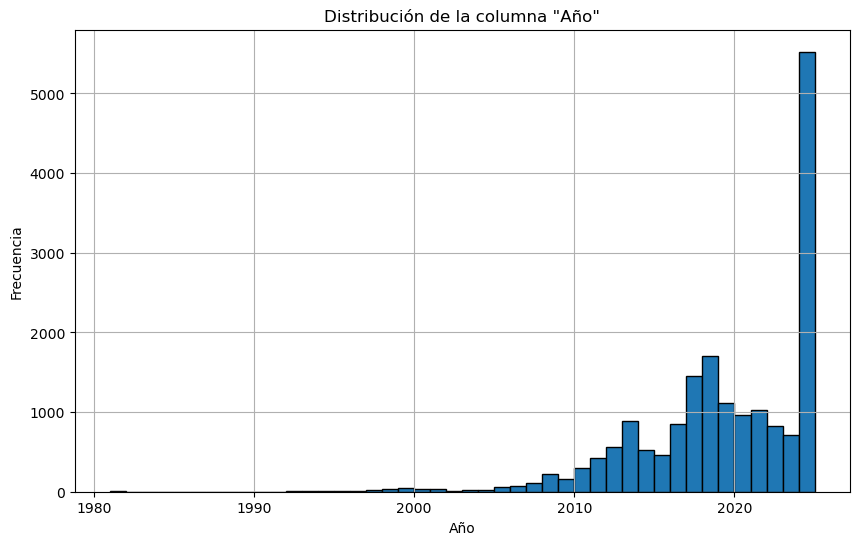

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(df["Año"], bins=44, edgecolor='black')
plt.title(f'Distribución de la columna "{"Año"}"')
plt.xlabel("Año")
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Hay pocas muestras de autos viejos, capaz estaria bueno nivelarlas con alguno de los metodos que habiamos dado

# distribución puertas

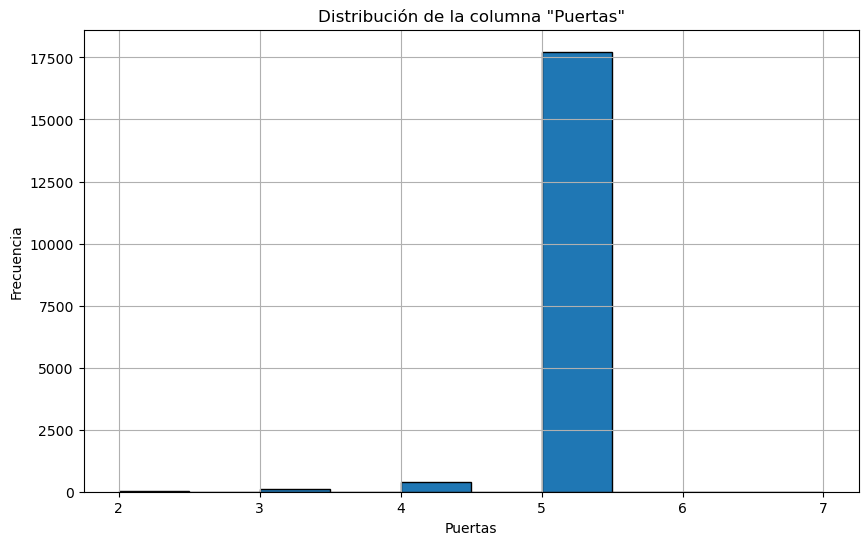

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(df["Puertas"], bins=10, edgecolor='black')
plt.title(f'Distribución de la columna "{"Puertas"}"')
plt.xlabel("Puertas")
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Creo que no existen vehiculos de 2, 4, 6 o 7 puertas, habria que chequear eso. 

# distribucion precio

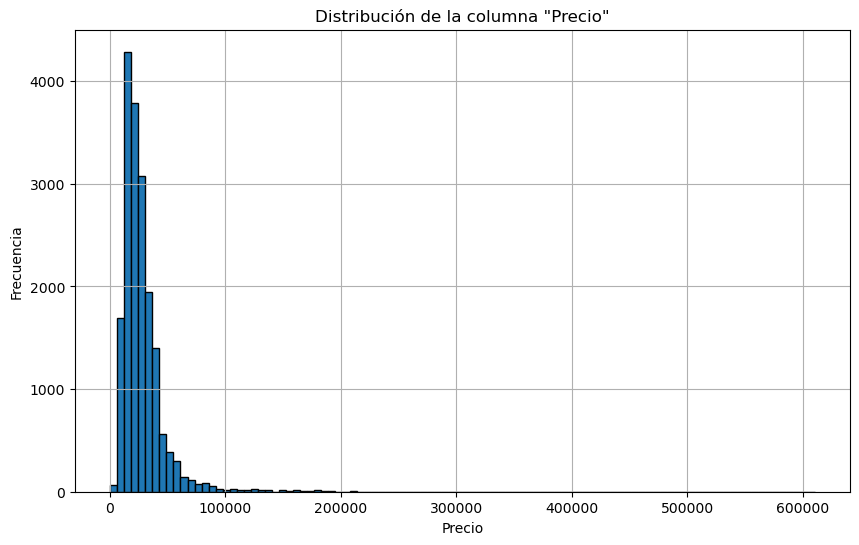

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(df["Precio"], bins=100, edgecolor='black')
plt.title(f'Distribución de la columna "{"Precio"}"')
plt.xlabel("Precio")
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [10]:
df["Precio"].describe()  


count     18253.000000
mean      27598.044551
std       20297.864206
min         100.421941
25%       16033.755274
50%       23500.000000
75%       32489.450633
max      610000.000000
Name: Precio, dtype: float64

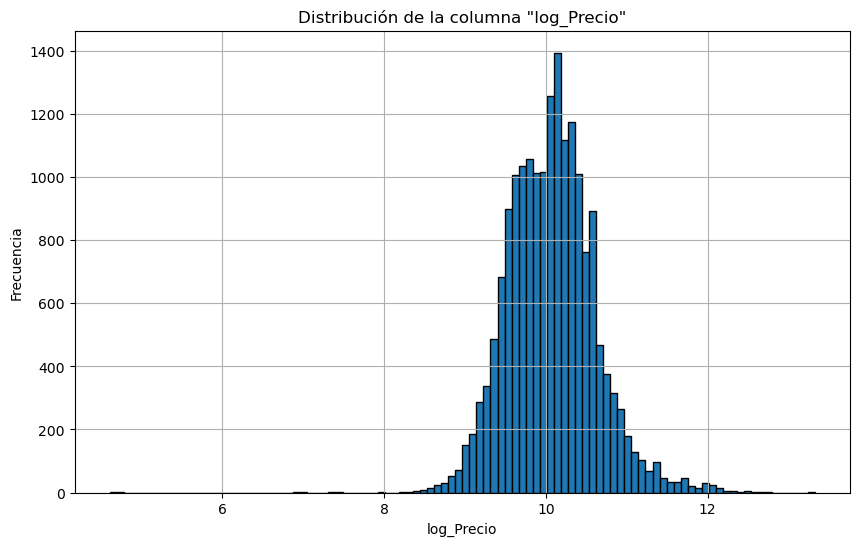

Número de outliers: 187


In [11]:
df["log_Precio"] = np.log(df["Precio"])
plt.figure(figsize=(10, 6))
plt.hist(df["log_Precio"], bins=100, edgecolor='black')
plt.title(f'Distribución de la columna "{"log_Precio"}"')
plt.xlabel("log_Precio")
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

mu = df["log_Precio"].mean()
sigma = df["log_Precio"].std()

# Outliers a más de 3 sigmas de la media
outliers = df[np.abs(df["log_Precio"] - mu) > 3 * sigma]
print(f"Número de outliers: {len(outliers)}")

In [12]:
df= df[np.abs(df["log_Precio"] - mu) <= 3 * sigma].copy()
df["Precio"] = np.exp(df["log_Precio"])


# codificacion

In [13]:
mappings = {
    'Con cámara de retroceso': {'No': 0, 'Sí': 1},
    'Transmisión': {
        'Automática': 0,
        'Manual': 1,
        'Automática secuencial': 2,
        'Semiautomática': 3
    }
}

for col, mapping in mappings.items():
    code_col = col.replace(' ', '_') + '_code'
    df[code_col] = df[col].map(mapping)

enc = OrdinalEncoder()
df[['Modelo_code', 'Version_code']] = enc.fit_transform(df[['Modelo', 'Versión']])

imputer = KNNImputer(n_neighbors=5, weights='uniform')
cols_to_impute = ['Modelo_code', 'Año', 'Version_code'] + [c.replace(' ', '_') + '_code' for c in mappings]
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

for col, mapping in mappings.items():
    code_col = col.replace(' ', '_') + '_code'
    df[code_col] = np.round(df[code_col]).astype(int)
    inv_map = {v: k for k, v in mapping.items()}
    df[col] = df[code_col].map(inv_map)

df['Puertas'] = df['Puertas'].replace(60252.0, np.nan)
imputer = KNNImputer(n_neighbors=5)
cols = ['Modelo_code', 'Año','Version_code','Puertas']
df[cols] = imputer.fit_transform(df[cols])
df['Puertas'] = np.round(df['Puertas']).astype(int)

aux_cols = ['Modelo_code', 'Version_code'] + [c.replace(' ', '_') + '_code' for c in mappings]
df.drop(aux_cols, axis=1, inplace=True)

print(df['Puertas'].value_counts(dropna=False))
print(df['Con cámara de retroceso'].value_counts(dropna=False))
print(df['Transmisión'].value_counts(dropna=False))

df['Kilómetros'] = (
    df['Kilómetros']
      .str.replace(r'\s*km$', '', regex=True)  
      .str.replace(r'\.', '', regex=True)      
      .astype(float)
)
print( df['Kilómetros'].value_counts(dropna=False))

Puertas
5    17570
4      387
3       94
2       10
6        3
7        2
Name: count, dtype: int64
Con cámara de retroceso
Sí    13580
No     4486
Name: count, dtype: int64
Transmisión
Automática               12127
Manual                    5823
Automática secuencial      115
Semiautomática               1
Name: count, dtype: int64
Kilómetros
0.0          4460
10000.0       217
1200000.0     194
900000.0      194
1000000.0     176
             ... 
962020.0        1
808000.0        1
3710000.0       1
918000.0        1
639000.0        1
Name: count, Length: 2140, dtype: int64


In [14]:
print(df.columns)
#Marca,Descripción,color
#Tipo de combustible,Motor,Tipo de vendedor,Versión,Título,Modelo
print( df['Color'].value_counts(dropna=False))


Index(['Marca', 'Modelo', 'Año', 'Versión', 'Color', 'Tipo de combustible',
       'Puertas', 'Transmisión', 'Motor', 'Con cámara de retroceso',
       'Kilómetros', 'Título', 'Precio', 'Descripción', 'Tipo de vendedor',
       'log_Precio'],
      dtype='object')
Color
Gris                 5402
Blanco               4782
Negro                2780
Plateado             1414
Rojo                 1115
                     ... 
MARRON KODIAK           1
blue                    1
BLACK MEET KETTLE       1
GRAY                    1
NOIR PERLA NERA         1
Name: count, Length: 71, dtype: int64
